# Neural Quantum Dynamics Emulator (Part III)

### Scope of this notebook

1. We include the full model test results.
2. We show how to calculate and visulize the input-feature importance.

In [33]:
# Computation Libraries
import numpy as np
import tensorflow as tf

# Graphic Libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style("whitegrid")
from IPython.display import HTML
import matplotlib.gridspec as gridspec

# Custom Libraries
from utils import *
from models import *

## Section 7: Full Models Results


We can plot the loss and correlation of all 25 hand made test cases simulated by the full model.

<Figure size 1296x864 with 0 Axes>

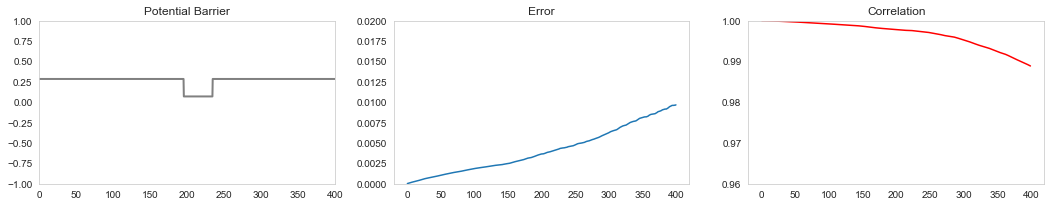

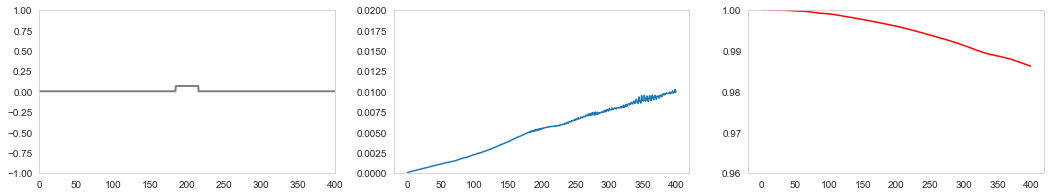

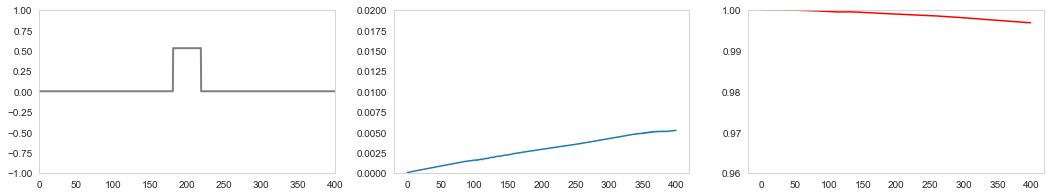

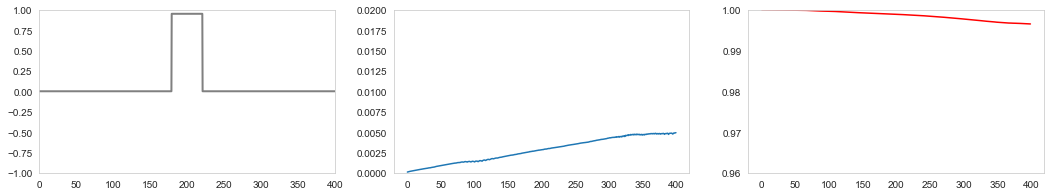

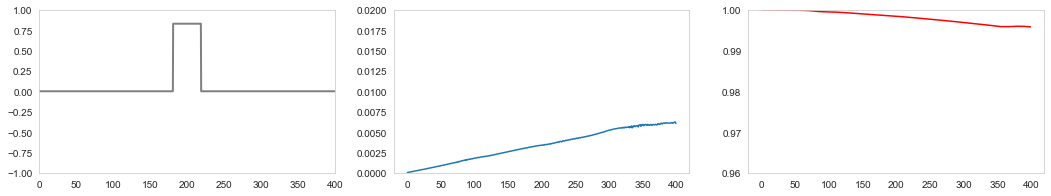

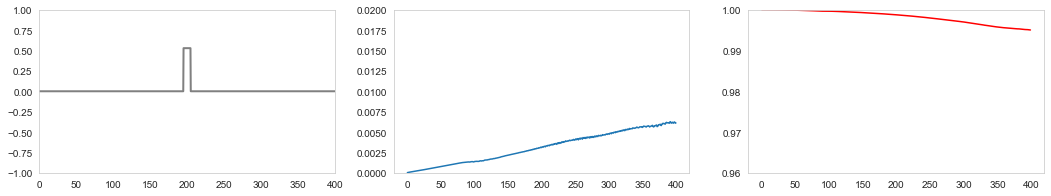

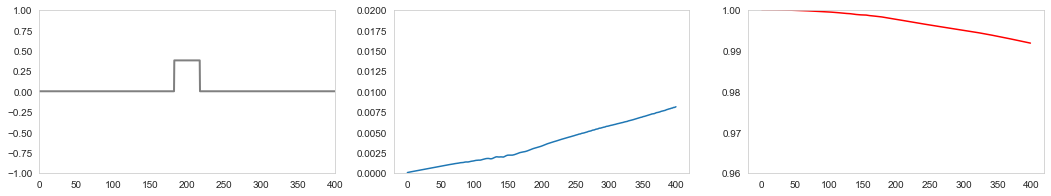

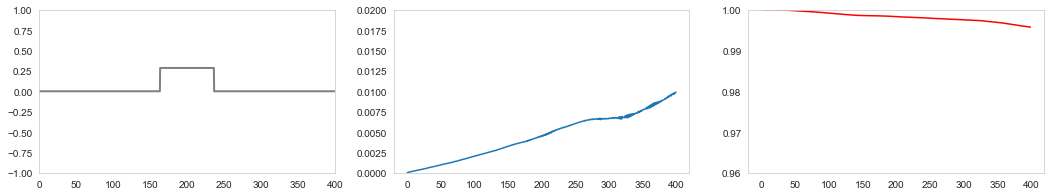

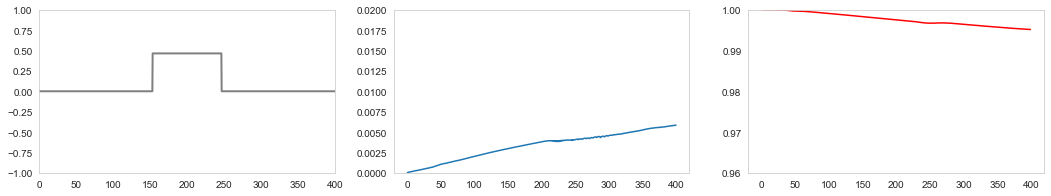

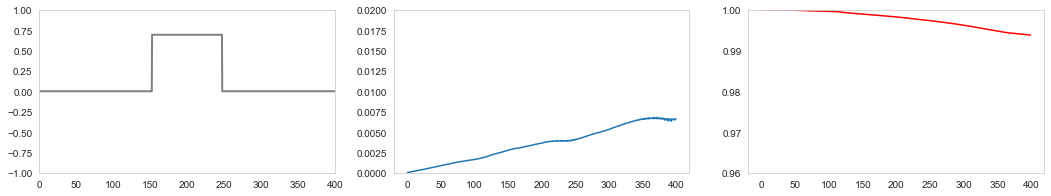

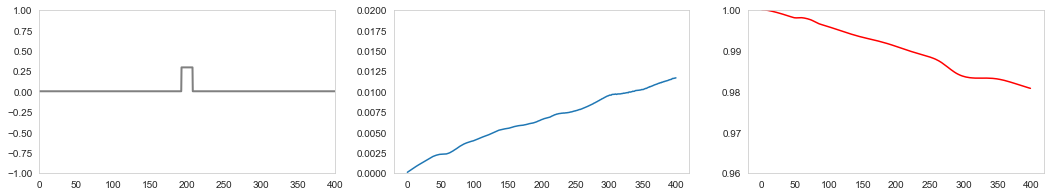

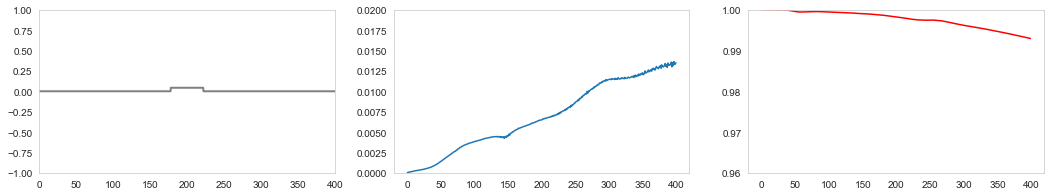

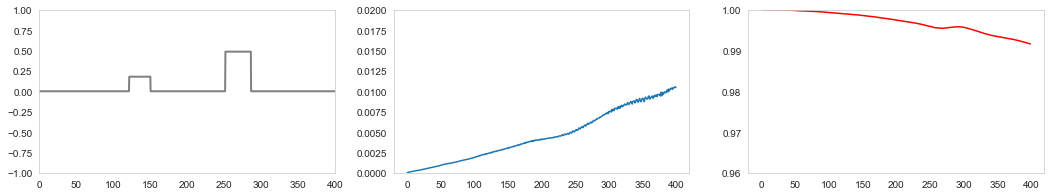

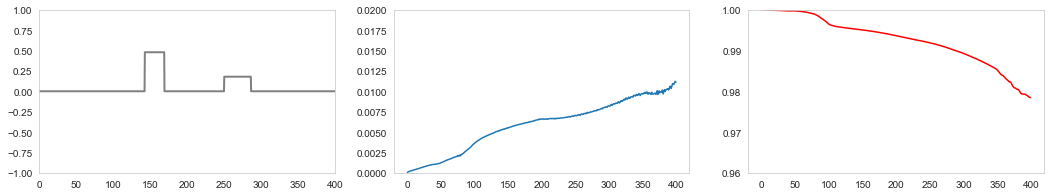

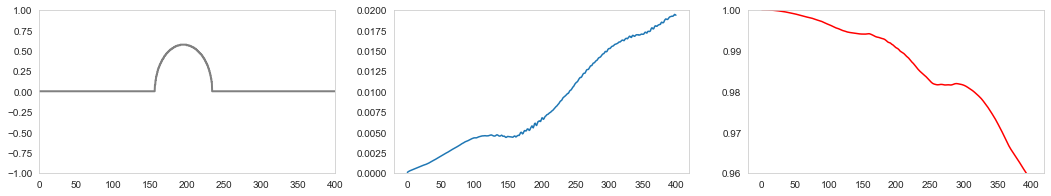

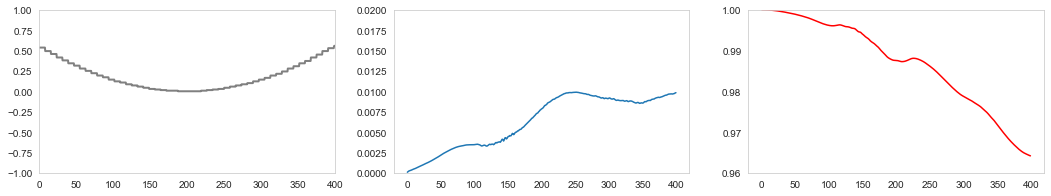

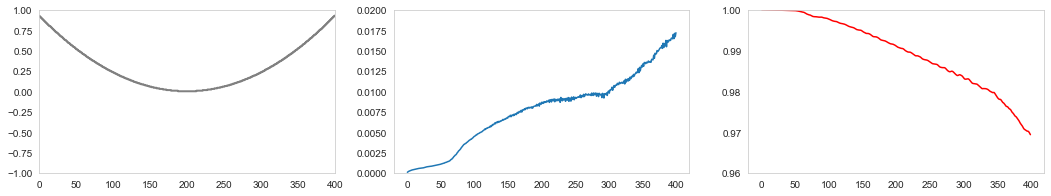

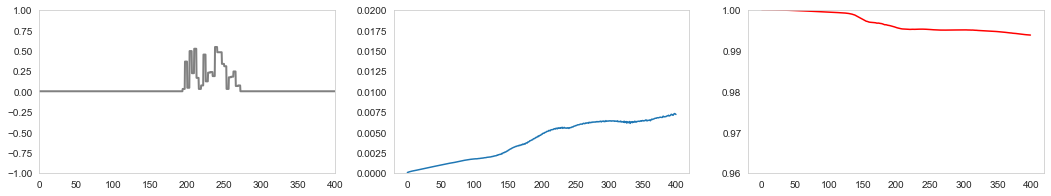

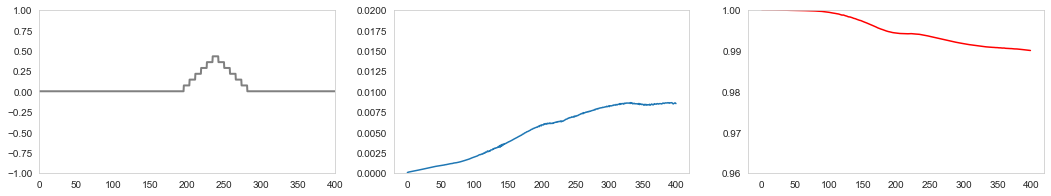

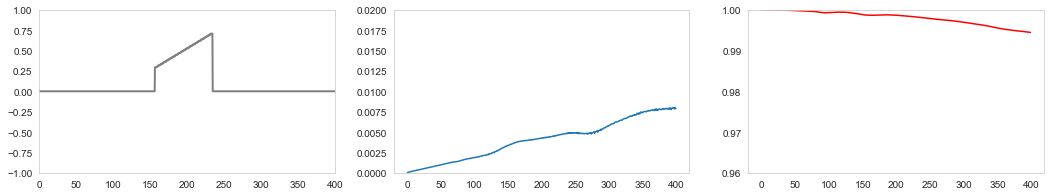

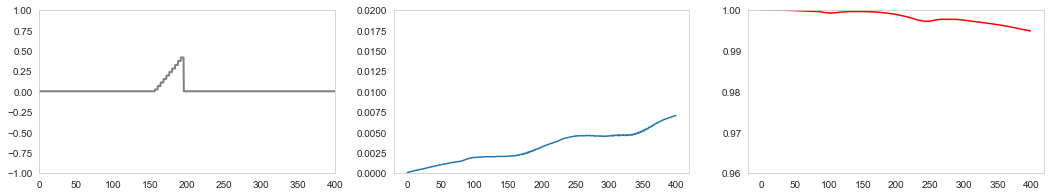

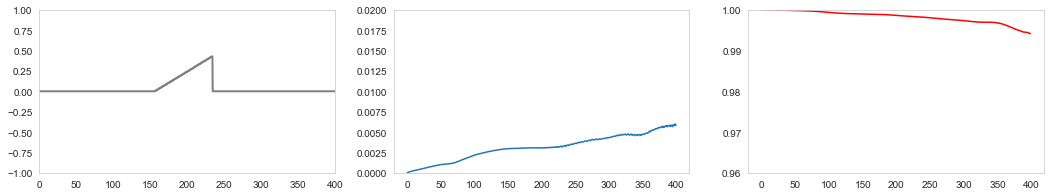

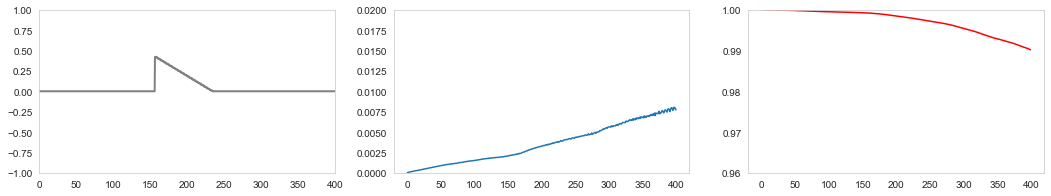

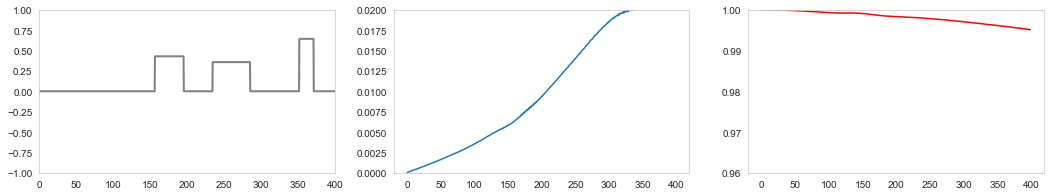

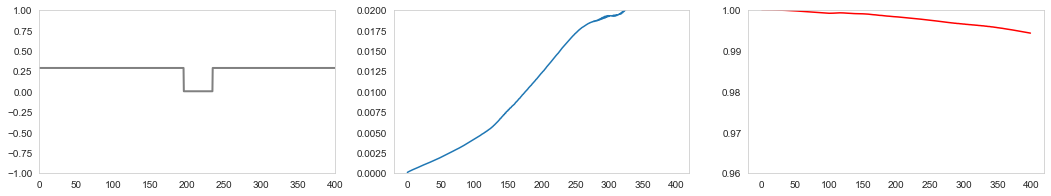

In [2]:
full_npz = np.load("full-gru-results.npz")
fig = plt.figure(figsize=(18,12))
test_files = sorted(tf.io.gfile.glob("../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/*.txt"))
corr = full_npz['all_corr']
loss = full_npz['all_loss']
plt.rcParams.update({'figure.max_open_warning': 0})
for i in range(25):
    data = retrieve_data(test_files[i-1],14.)
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,3))
    if i == 0:
        ax1.set_title('Potential Barrier')
        ax2.set_title('Error')
        ax3.set_title('Correlation')
        
    #Plot Potential
    ax1.grid(False)
    ax1.set_xlim(0,400)
    ax1.set_ylim(-1,1)
    x = np.linspace(0, 400, int(data["params"][0][0]))
    line = ax1.plot([], [], lw=2, color="gray")[0]
    line.set_data(x,data['pot'][0])
    
    #Plot Error
    ax2.grid(False)
    ax2.plot(loss[0,i,:])
    ax2.set_ylim(0,0.02)
    
    #Plot Correlation
    ax3.grid(False)
    ax3.plot(corr[0,i,:], color='r')
    ax3.set_ylim(0.96,1)

plt.show()

We can build the animation for a specific model with a specific test file to see the actual performance of it. After that, we plot the ground truth, prediction and the difference.

This first case is the "Easy" case with a single rectangular potential barrier.

In [12]:
test_file = "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/X0_15.1_S0_1.7_E0_6.4_BH_7.4_BW_9.4.txt"
model = RNNModel
config = Config()
full_ckpt = "../models/full-gru/ckpts/final_step"
HTML(show_animation(config,model,full_ckpt,test_file))

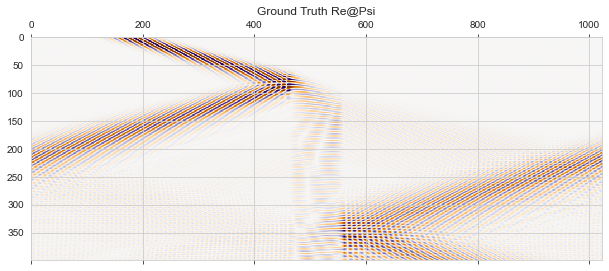

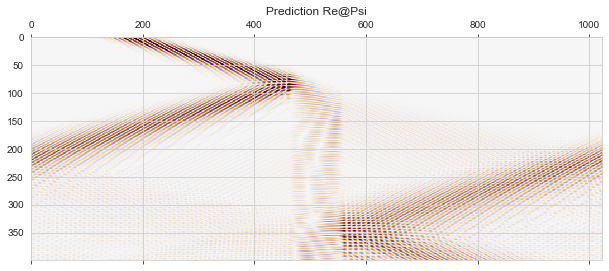

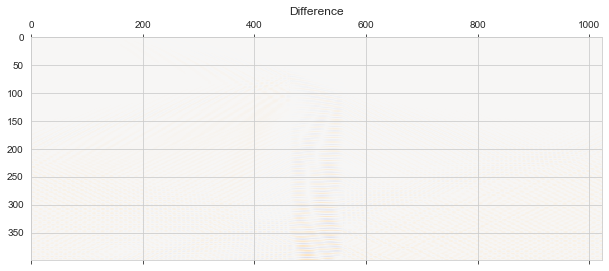

In [42]:
data = retrieve_data(test_file,14.)
config = Config()
model = RNNModel(config)
model.load_weights(full_ckpt)
result = get_result(model,config,data)
frames = result.shape[0]

plt.matshow(data["psi_re"][config.input_frames:config.input_frames+frames], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title("Ground Truth Re@Psi")
plt.matshow(result[:, :, 0], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title("Prediction Re@Psi")

plt.matshow(data["psi_re"][config.input_frames:config.input_frames+frames]-result[:, :, 0], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title("Difference")

plt.show()

This second case is the "Intermediate" case with three potential barriers with different potentials.

In [43]:
test_file = "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/triple.txt"
model = RNNModel
config = Config()
full_ckpt = "../models/full-gru/ckpts/final_step"
HTML(show_animation(config,model,full_ckpt,test_file))

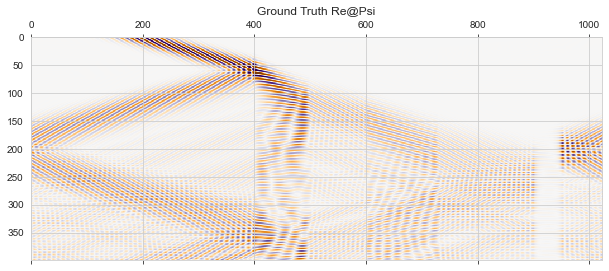

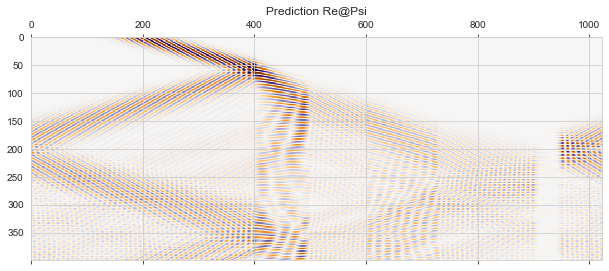

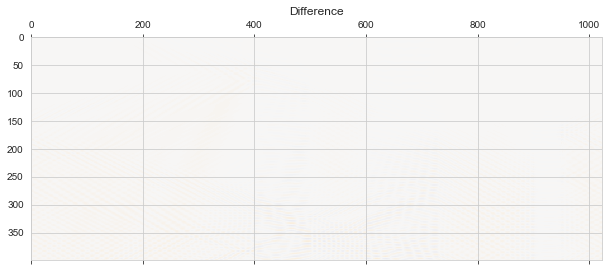

In [44]:
data = retrieve_data(test_file,14.)
config = Config()
model = RNNModel(config)
model.load_weights(full_ckpt)
result = get_result(model,config,data)
frames = result.shape[0]

plt.matshow(data["psi_re"][config.input_frames:config.input_frames+frames], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title("Ground Truth Re@Psi")
plt.matshow(result[:, :, 0], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title("Prediction Re@Psi")

plt.matshow(data["psi_re"][config.input_frames:config.input_frames+frames]-result[:, :, 0], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title("Difference")

plt.show()

This third case is the "Complex" case with a random potential barrier.

In [45]:
test_file = "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/random.txt"
model = RNNModel
config = Config()
full_ckpt = "../models/full-gru/ckpts/final_step"
HTML(show_animation(config,model,full_ckpt,test_file))

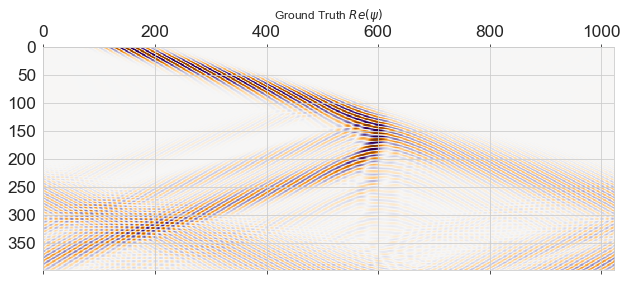

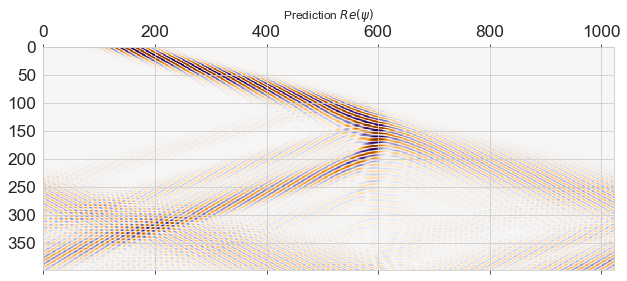

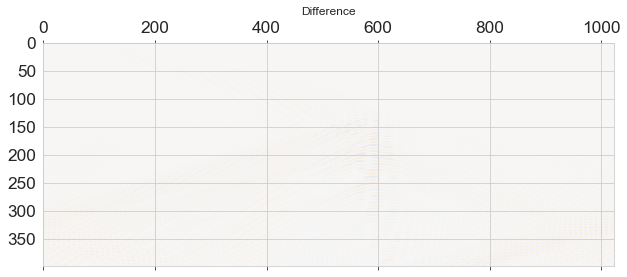

In [53]:
data = retrieve_data(test_file,14.)
config = Config()
model = RNNModel(config)
model.load_weights(full_ckpt)
result = get_result(model,config,data)
frames = result.shape[0]

plt.matshow(data["psi_re"][config.input_frames:config.input_frames+frames], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title("Ground Truth Re@Psi")
plt.matshow(result[:, :, 0], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title("Prediction Re@Psi")

plt.matshow(data["psi_re"][config.input_frames:config.input_frames+frames]-result[:, :, 0], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title("Difference")

plt.show()

## Section 8: Input-feature Importance


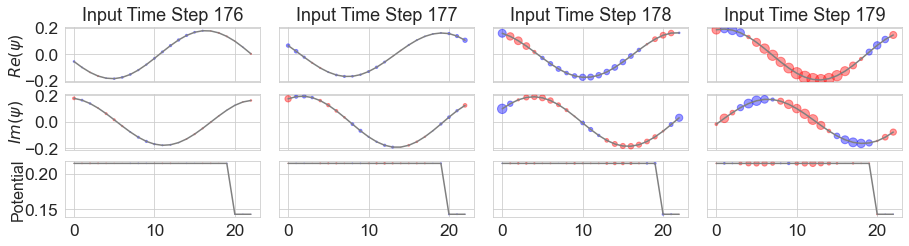

In [56]:
def compute_gradients(model, inputs, target):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        pred = model(inputs)
        pred = pred[0, target[0], target[1]]
    return tape.gradient(pred, inputs)


def plot_g(model, config, data, frame_num=0, window_num=500, target=(11, 0), bp=True):
    def build_plot(config, feature, resp, window_num):
        ylabel = ["$Re(\psi)$", "$Im(\psi)$", "Potential"]
        fig, axs = plt.subplots(3, 4, sharex=True, sharey='row', figsize=(15,3.5), )
        resp = resp.reshape(feature.shape)
        for i in range(4):
            for j in range(config.input_channels):
                x = np.arange(feature.shape[1])
                y = feature[i, :, j]
                s = resp[i, :, j]
                axs[j, i].plot(y, c="gray")
                
                spos = np.maximum(s, 0)
                sneg = np.minimum(s, 0)
                axs[j, i].scatter(x, y, c="red", s=1e3*np.abs(spos), alpha=0.4,)
                axs[j, i].scatter(x, y, c="blue", s=1e3*np.abs(sneg), alpha=0.4,)
                
                if j == 0:
                    axs[j, i].set_title(f"Input Time Step {i+176}", fontsize=18)
                if i == 0:
                    axs[j, i].set_ylabel(ylabel[j], fontsize=16)
                    axs[j, i].yaxis.set_label_coords(-0.2, 0.5)
                    
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        plt.grid("False")


    features = tf.stack((tf.constant(data["psi_re"], dtype=tf.float32), 
                         tf.constant(data["psi_im"], dtype=tf.float32), 
                         tf.constant(data["pot"], dtype=tf.float32)), axis=-1)
    feature = features[frame_num:frame_num+config.input_frames, window_num:window_num+config.window_size, :config.input_channels].numpy()
    
    g = compute_gradients(model, tf.constant([feature]), target=target)
    if bp:
        build_plot(config, feature, g.numpy(), window_num)
    return g.numpy()


test_file = "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/steps.txt"
pot_scalar = 14.
ckpt = "../models/full-gru/ckpts/final_step"
config = Config()
model = RNNModel(config)
data = retrieve_data(test_file, pot_scalar)
model.load_weights(ckpt)
g = plot_g(model, config, data, 176, 660, (11, 0))

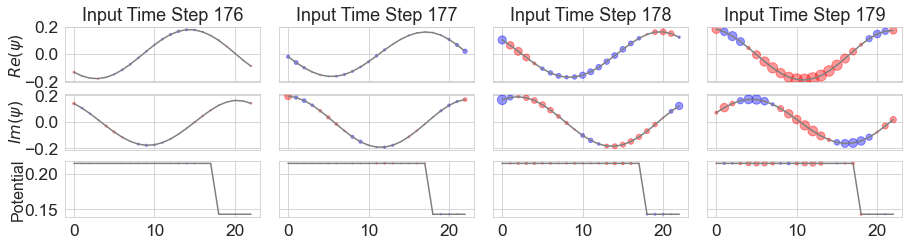

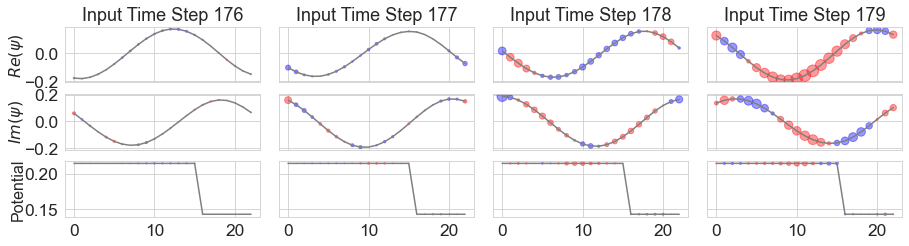

In [61]:
g = plot_g(model, config, data, 176, 662, (11, 0))
g = plot_g(model, config, data, 176, 664, (11, 0))